In [7]:
%matplotlib inline 
import numpy as np
from numpy import sqrt, log
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import pandas as pd
import seaborn as sns

In [8]:
# Set Paramaters
np.random.seed(seed = 13)

Tc_list = [1,5,10,15,20,25,30,35]
t0, Tend0 = 3, 60

# Read Data
X = pd.read_csv('SOStotal.csv', na_values = '#VALUE!', index_col = 0)
X.dropna(how = 'any', axis = 1, inplace = True)
X.set_axis(['{}'.format(n) for n in range(X.shape[1])], axis ='columns', inplace = True)
X = X.to_numpy()

Y = pd.read_csv('RAFtotal.csv', na_values = '#VALUE!', index_col = 0)
Y.dropna(how = 'any', axis = 1, inplace = True)
Y.set_axis(['{}'.format(n) for n in range(Y.shape[1])], axis ='columns', inplace = True)
Y = Y.to_numpy()    

# Length of TIme Serires
T = X.shape[0]
time = np.array([t for t in range(T)]) -3

# Sample Size
NSAMP = X.shape[1]

n = len(Tc_list)
time_list = np.arange(0,Tend0+1)

# Data Concatenation 
x = np.zeros((2, T, NSAMP))
x[0, :, :] = X
x[1, :, :] = Y
z = np.concatenate([x[0, :, :], x[1, :, :]], axis = 0)
C_tot = np.cov(z)


In [9]:
#Assessment of TE for Various Tc, Tr
EPS = 1.0e-8 

TE_x2y_dict = {} 
TE_y2x_dict = {}

for nc in range(n): 
    Tc = Tc_list[nc]+3 
    Tr = Tc_list[nc]+3 
    TE_y2x = np.zeros((T,)) 
    TE_x2y = np.zeros((T,))
        
    for t in range(Tr+1,T):
        ux = np.concatenate((x[0, Tc: Tc+1, :], x[1, Tr: Tr+1, :]), axis = 0)
        uy = np.concatenate((x[0, Tr: Tr+1, :], x[1, Tc: Tc+1, :]), axis = 0)

        # TE_y2x
        z = np.concatenate((x[0, t, :].reshape(1,uy.shape[1]), uy), axis = 0)
        C = np.cov(z)
        Vx_xy = C[0,0] - C[0,1:]@np.linalg.inv(C[1:,1:] + EPS*np.eye(2))@C[1:,0]
        Vx_x = C[0,0] - C[0,1:2]@np.linalg.inv(C[1:2, 1:2] + EPS*np.eye(1))@C[1:2, 0]
        TE_y2x[t] = 1/2*log(Vx_x/Vx_xy)

        # TE_x2y
        z = np.concatenate((x[1, t, :].reshape(1,ux.shape[1]), ux), axis = 0)
        C = np.cov(z)
        Vy_xy = C[0,0] - C[0,1:]@np.linalg.inv(C[1:,1:] + EPS*np.eye(2))@C[1:,0]
        Vy_y = C[0,0] - C[0, 2:]@np.linalg.inv(C[2:, 2:] + EPS*np.eye(1))@C[2:, 0]
        TE_x2y[t] = 1/2*log(Vy_y/Vy_xy)

    TE_y2x_dict['{}{}'.format(Tc,Tr)] = TE_y2x            
    TE_x2y_dict['{}{}'.format(Tc,Tr)] = TE_x2y
        

In [10]:
# Bootstrap Assessment of Sampling Distribution for Null Hypothesis 
B = 1000

# Null Hypothesis 
C_null = C_tot
C_null[:T, T:] = np.zeros((T,T)) 
C_null[T:, :T] = np.zeros((T,T)) 
LAM, U = np.linalg.eigh(C_null)

TE_y2x_shuffled_dict = {}
TE_x2y_shuffled_dict = {}

for nc in range(n):
    Tc = Tc_list[nc]+3
    Tr = Tc_list[nc]+3
    TE_y2x_shuffled = np.zeros((T, B))
    TE_x2y_shuffled = np.zeros((T, B))

    for b in range(B):

        # Generation of Bootstrap Data
        x_BS = np.zeros((2,T, NSAMP))
        u = U@np.diag(sqrt(abs(LAM)))@np.random.randn(2*T, NSAMP)
        x_BS[0, :, :] = u[:T, :]
        x_BS[1, :, :] = u[T:, :]

        for t in range(Tr+1,T):
            ux = np.concatenate((x_BS[0, Tc: Tc+1, :], x_BS[1, Tr: Tr+1, :]), axis = 0)
            uy = np.concatenate((x_BS[0, Tr: Tr+1, :], x_BS[1, Tc: Tc+1, :]), axis = 0) 

            # TE_y2x
            z = np.concatenate((x_BS[0, t, :].reshape(1,uy.shape[1]), uy), axis = 0)
            C = np.cov(z)
            Vx_xy = C[0,0] - C[0,1:]@np.linalg.inv(C[1:,1:] + EPS*np.eye(2))@C[1:,0]
            Vx_x = C[0,0] - C[0,1:2]@np.linalg.inv(C[1:2, 1:2] + EPS*np.eye(1))@C[1:2, 0]
            TE_y2x_shuffled[t, b] = 1/2*log(Vx_x/Vx_xy)

            # TE_x2y
            z = np.concatenate((x_BS[1, t, :].reshape(1,ux.shape[1]), ux), axis = 0)
            C = np.cov(z)
            Vy_xy = C[0,0] - C[0,1:]@np.linalg.inv(C[1:,1:] + EPS*np.eye(2))@C[1:,0]
            Vy_y = C[0,0] - C[0, 2:]@np.linalg.inv(C[2:, 2:] + EPS*np.eye(1))@C[2:, 0]
            TE_x2y_shuffled[t, b] = 1/2*log(Vy_y/Vy_xy)

        TE_y2x_shuffled_dict['{}{}'.format(Tc,Tr)] = TE_y2x_shuffled
        TE_x2y_shuffled_dict['{}{}'.format(Tc,Tr)] = TE_x2y_shuffled   


In [11]:
# Evaluation & Save results
pr = 0.01

TE_x2y_ps, TE_y2x_ps = np.zeros((n,n,T)), np.zeros((n,n,T))

for nc in range(n):
    Tc = Tc_list[nc]+3
    Tr = Tc_list[nc]+3
    x2y_sig, y2x_sig = np.zeros(T), np.zeros(T)

    x2y = TE_x2y_dict['{}{}'.format(Tc,Tr)]
    x2y_shuffled = TE_x2y_shuffled_dict['{}{}'.format(Tc,Tr)]

    y2x = TE_y2x_dict['{}{}'.format(Tc,Tr)]
    y2x_shuffled = TE_y2x_shuffled_dict['{}{}'.format(Tc,Tr)]

    x2y_shuffled[t,:] = np.sort(x2y_shuffled[t,:])
    y2x_shuffled[t,:] = np.sort(y2x_shuffled[t,:])

    for t in range(T):
        if x2y[t] > x2y_shuffled[t, B-int(pr*B)]: 
            x2y_sig[t] = x2y[t]
        if y2x[t] > y2x_shuffled[t, B-int(pr*B)]:
            y2x_sig[t] = y2x[t]

        TE_x2y_ps[nc][nc][t] = x2y_sig[t]
        TE_y2x_ps[nc][nc][t] = y2x_sig[t]


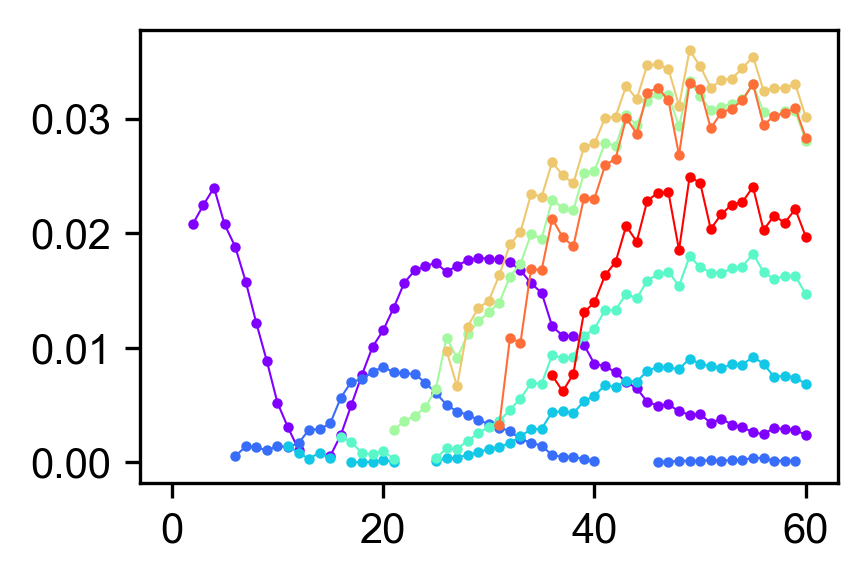

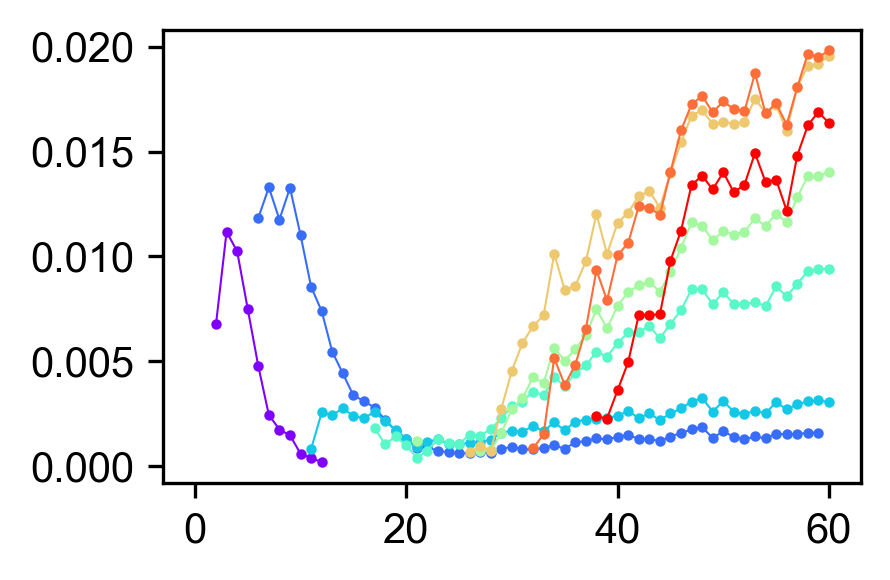

In [12]:
# plot (T TE;Tc=Tr)
rc('lines', linewidth=2)
rc('xtick', labelsize = 12)
rc('ytick', labelsize = 12)

fig = plt.figure(figsize = (3,2), dpi = 300)
plt.rcParams["font.family"] = "Arial"
plt.tick_params(labelsize = 10)

SigTE_x2y_ps, SigTE_y2x_ps = np.zeros((n,n,T)), np.zeros((n,n,T))

# x2y
for nc in range(8):
    SigTE_x2y_ps[nc, nc, :] = np.where(TE_x2y_ps[nc, nc, :] == 0, np.nan, TE_x2y_ps[nc, nc, :])
        
    plt.plot(time, SigTE_x2y_ps[nc, nc, :], linewidth = 0.5, 
                marker = ".", markersize = 3, color = cm.rainbow(nc/(n-1)))
    plt.xlim(-3, 63)

plt.show()

# y2x
fig = plt.subplots(figsize = (3,2), dpi = 300)
plt.rcParams["font.family"] = "Arial"
plt.tick_params(labelsize = 10)

for nc in range(8):
    SigTE_y2x_ps[nc, nc, :] = np.where(TE_y2x_ps[nc, nc, :] == 0, np.nan, TE_y2x_ps[nc, nc, :])
        
    plt.plot(time, SigTE_y2x_ps[nc, nc, :], linewidth = 0.5, 
            marker = ".", markersize = 3, color = cm.rainbow(nc/(n-1)))
    plt.xlim(-3, 63)

plt.show()